In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
import pandas as pd

from bpho import *

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
datasetname = 'combo_001'
data_path = Path('.')
datasets = data_path/'datasets'
datasources = data_path/'data'
dataset = datasets/datasetname

test_files = dataset/'test'
hr_tifs = dataset/'hr'
lr_tifs = dataset/'lr'
lr_up_tifs = dataset/'lr_up'

hr_multi_tifs = dataset/'hr_5_neuron'
lr_up_multi_tifs = dataset/'lr_up_5_neuron'

mname = 'combo_multi_neuron'
model_dir = 'models'

In [3]:
torch.cuda.set_device(0)

In [4]:
# code to build the multi-img files - shoudl be moved int build_combo

if False:
    fns = list(hr_tifs.glob('**/*.tif'))

    items = []
    movies = set()
    for fn in progress_bar(fns):
        parts = fn.stem.split('_')
        group = fn.relative_to(hr_tifs).parts[0]
        prefix = '_'.join(parts[:-1])
        frame = int(parts[-1])
        if 'neuron' in fn.stem:
            items.append(dict(fn=str(fn),prefix=prefix,group=group, frame=frame))
            movies.add((group, fn.parent/prefix))

    df = pd.DataFrame(items)
    
    wsize = 5
    batches = {}
    targets = {}
    for group, m in progress_bar(movies):
        m_prefix = m.stem
        movie_tifs = list(df.loc[df.prefix == m_prefix].sort_values('fn').fn.values)
        n_frames = len(movie_tifs)
        mid_idx = wsize//2
        for t in range(0, n_frames-wsize, wsize):
            #print(t, t+wsize)
            frame_batch = movie_tifs[t:(t+wsize)]
            if len(frame_batch) == wsize:
                bname = f'{m_prefix}_{t:06d}-{(t+wsize):06d}'
                target = movie_tifs[t+mid_idx]
                batches[bname] = (group, [Path(fn).name for fn in frame_batch])
                targets[bname] = (group, Path(target).name)

    hr_multi_tifs.mkdir(exist_ok=True)
    lr_up_multi_tifs.mkdir(exist_ok=True)
    for k in progress_bar(batches):
        group, batch = batches[k]
        _, target = targets[k]

        Path(hr_multi_tifs/group).mkdir(exist_ok=True)
        shutil.copy(hr_tifs/group/target, hr_multi_tifs/group/f'{k}.tif')

        Path(lr_up_multi_tifs/group).mkdir(exist_ok=True)
        multi_img_data = np.stack([np.array(PIL.Image.open(lr_up_tifs/group/fn)) for fn in batch])
        np.save(lr_up_multi_tifs/group/f'{k}.npy' ,multi_img_data)

In [5]:
def get_src(x_data, y_data_):
    def map_to_hr(x):
        hr_name = x.relative_to(x_data).with_suffix('.tif')
        return y_data_/hr_name
    
    src = (MultiImageImageList
            .from_folder(x_data, extensions=['.npy'])
            .split_by_rand_pct()
            .label_from_func(map_to_hr, convert_mode='L'))
    return src


def get_data(bs, size, x_data, y_data, max_zoom=1.1):
    src = get_src(x_data, y_data)
    tfms = get_transforms(flip_vert=True, max_lighting=None, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs))
    data.c = 3
    return data


def do_fit(learn, save_name, lrs=slice(1e-3), pct_start=0.9, cycle_len=10):
    learn.to_fp16().fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    print(f'saved: {save_name}')
    num_rows = min(learn.data.batch_size, 3)
    learn.to_fp32().show_results(rows=num_rows, imgsize=5)


def get_model(in_c, out_c, arch):
    body = nn.Sequential(*list(arch(c_in=in_c).children())[:-2])
    model = DynamicUnet(
        body, n_classes=out_c,
        blur=True, blur_final=True,
        self_attention=True, norm_type=NormType.Weight, 
        last_cross=True, bottle=True
    )
    return model


In [13]:
step = 0
lr = 1e-3
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 16
size = 256
max_zoom = 6
arch = xresnet34

data = get_data(bs, size, lr_up_multi_tifs, hr_multi_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, in_c=5, loss_func=loss, metrics=metrics, model_dir=model_dir)
gc.collect()

0

In [14]:
if False:
    learn.lr_find()
    learn.recorder.plot()

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.000205,0.000146,0.849308,38.356560,00:20
1,0.000122,0.000060,0.959958,42.230255,00:20


saved: combo_multi_neuron.00


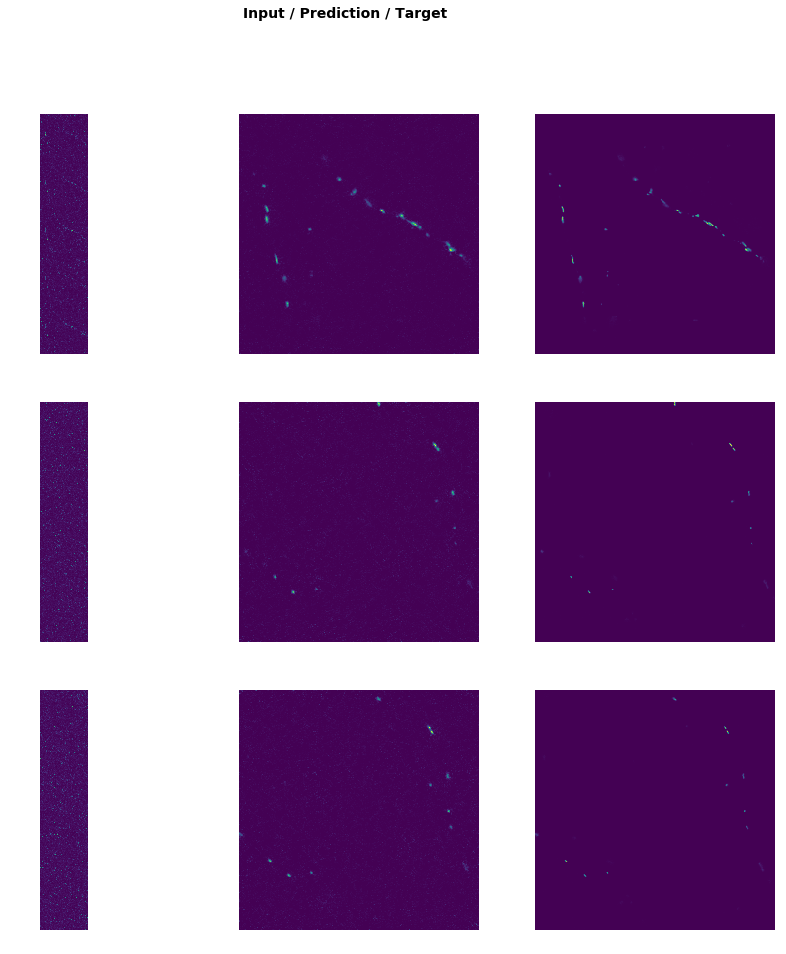

In [17]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [18]:
step = 1
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 8
size = 512
max_zoom = 4
arch = xresnet34

data = get_data(bs, size, lr_up_multi_tifs, hr_multi_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, in_c=5, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()

0

In [19]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.000067,0.000065,0.960325,42.098873,00:51
1,0.000062,0.000057,0.970701,42.664825,00:51


saved: combo_multi_neuron.01


RuntimeError: CUDA out of memory. Tried to allocate 872.00 MiB (GPU 0; 23.62 GiB total capacity; 12.13 GiB already allocated; 713.00 MiB free; 2.12 GiB cached)

In [6]:
step = 2
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 2
size = 1024
max_zoom = 2
arch = xresnet34

data = get_data(bs, size, lr_up_multi_tifs, hr_multi_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, in_c=5, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()

0

In [7]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.000055,0.000045,0.973036,44.208363,03:59
1,0.000051,0.000040,0.982005,44.705391,03:54


saved: combo_multi_neuron.02


RuntimeError: CUDA out of memory. Tried to allocate 872.00 MiB (GPU 0; 23.62 GiB total capacity; 14.28 GiB already allocated; 56.00 MiB free; 618.66 MiB cached)

In [6]:
fns = []
fns += list(test_files.glob('**/*.czi')) 
fns += list(test_files.glob('**/*.tif'))

items = []
movies = set()
for fn in progress_bar(fns):
    parts = fn.stem.split('_')
    group = fn.relative_to(test_files).parts[0]
    if 'neuron' in group:
        items.append(dict(fn=str(fn),group=group))
        movies.add((group, fn))

df = pd.DataFrame(items)
df.groupby('group').fn.count()

group
neurons    20
Name: fn, dtype: int64

In [7]:
movie_files = [Path(fn) for fn in list(df.fn.values)]
len(movie_files)

20

In [8]:
step = 2
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 1
size = 440*4
max_zoom = 2
arch = xresnet34

data = get_data(bs, size, lr_up_multi_tifs, hr_multi_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, in_c=5, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{step:02d}').to_fp16()
gc.collect()

0

In [9]:
generate_movies(movie_files, learn, size, wsize=5)

czi: x:380 y:380 t:1500 z:1
1.0


czi: x:380 y:380 t:300 z:1
0.7254902


czi: x:380 y:380 t:1200 z:1
1.0


czi: x:380 y:380 t:1500 z:1
0.92156863


czi: x:380 y:380 t:300 z:1
1.0


czi: x:380 y:380 t:1200 z:1
1.0


czi: x:440 y:440 t:1600 z:1
0.34509805


czi: x:440 y:440 t:730 z:1
1.0


czi: x:440 y:440 t:1600 z:1
0.20392157


czi: x:440 y:440 t:786 z:1
0.42745098


czi: x:380 y:380 t:300 z:1
0.87058824


czi: x:380 y:380 t:300 z:1
0.6784314


czi: x:440 y:440 t:1600 z:1
0.3137255


czi: x:380 y:380 t:1200 z:1
1.0


czi: x:440 y:440 t:1600 z:1
0.21960784


czi: x:380 y:380 t:1500 z:1
0.9254902


czi: x:380 y:380 t:2000 z:1


MemoryError: 